In [ ]:
!pip install earthengine-api geemap pandas numpy scikit-learn

import ee
import geemap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

ee.Authenticate()
ee.Initialize(project='rock-tower-462119-b0')

urban_rural_pairs = [
    (ee.Geometry.Rectangle([-82.4700, 27.9350, -82.4200, 27.9750]), ee.Geometry.Rectangle([-82.2400, 28.2200, -82.1900, 28.2600])),
    (ee.Geometry.Rectangle([-73.99, 40.75, -73.94, 40.79]), ee.Geometry.Rectangle([-74.25, 41.0, -74.2, 41.05])),
    (ee.Geometry.Rectangle([72.85, 19.0, 72.90, 19.05]), ee.Geometry.Rectangle([73.10, 19.20, 73.15, 19.25])),
    (ee.Geometry.Rectangle([2.29, 48.85, 2.34, 48.89]), ee.Geometry.Rectangle([2.60, 49.10, 2.65, 49.15])),
    (ee.Geometry.Rectangle([-99.175, 19.40, -99.125, 19.45]), ee.Geometry.Rectangle([-98.80, 19.75, -98.75, 19.80])),
    (ee.Geometry.Rectangle([31.2, 30.0, 31.25, 30.05]), ee.Geometry.Rectangle([31.5, 30.3, 31.55, 30.35])),
    (ee.Geometry.Rectangle([139.70, 35.65, 139.75, 35.70]), ee.Geometry.Rectangle([140.0, 35.90, 140.05, 35.95])),
    (ee.Geometry.Rectangle([116.38, 39.90, 116.43, 39.95]), ee.Geometry.Rectangle([116.80, 40.20, 116.85, 40.25])),
    (ee.Geometry.Rectangle([10.00, 53.55, 10.05, 53.60]), ee.Geometry.Rectangle([10.4, 53.9, 10.45, 53.95])),
    (ee.Geometry.Rectangle([151.2, -33.9, 151.25, -33.85]), ee.Geometry.Rectangle([151.5, -34.1, 151.55, -34.05])),
    (ee.Geometry.Rectangle([121.45, 31.20, 121.50, 31.25]), ee.Geometry.Rectangle([121.15, 31.55, 121.20, 31.60])),
    (ee.Geometry.Rectangle([-58.45, -34.62, -58.40, -34.57]), ee.Geometry.Rectangle([-58.75, -34.30, -58.70, -34.25])),
    (ee.Geometry.Rectangle([90.38, 23.73, 90.43, 23.78]), ee.Geometry.Rectangle([90.70, 24.05, 90.75, 24.10])),
    (ee.Geometry.Rectangle([-0.15, 51.50, -0.10, 51.55]), ee.Geometry.Rectangle([0.20, 51.80, 0.25, 51.85])),
    (ee.Geometry.Rectangle([-3.72, 40.40, -3.67, 40.45]), ee.Geometry.Rectangle([-3.40, 40.75, -3.35, 40.80])),
    (ee.Geometry.Rectangle([-79.42, 43.65, -79.37, 43.70]), ee.Geometry.Rectangle([-79.10, 44.00, -79.05, 44.05])),
    (ee.Geometry.Rectangle([100.48, 13.72, 100.53, 13.77]), ee.Geometry.Rectangle([100.20, 14.05, 100.25, 14.10])),
    (ee.Geometry.Rectangle([28.05, -26.22, 28.10, -26.17]), ee.Geometry.Rectangle([27.70, -25.85, 27.75, -25.80])),
    (ee.Geometry.Rectangle([126.95, 37.50, 127.00, 37.55]), ee.Geometry.Rectangle([127.25, 37.85, 127.30, 37.90])),
    (ee.Geometry.Rectangle([103.82, 1.28, 103.87, 1.33]), ee.Geometry.Rectangle([103.50, 1.60, 103.55, 1.65]))
]

regions = [
    'Tampa', 'New York', 'Mumbai', 'Paris', 'Mexico City', 'Cairo', 'Tokyo', 'Beijing', 'Hamburg', 'Sydney',
    'Shanghai', 'Buenos Aires', 'Dhaka', 'London', 'Madrid', 'Toronto', 'Bangkok', 'Johannesburg', 'Seoul', 'Singapore'
]

srtm = ee.Image("USGS/SRTMGL1_003")
ghsl_unscaled = ee.ImageCollection("JRC/GHSL/P2023A/GHS_BUILT_S").select('built_surface').first()
ghsl = ghsl_unscaled.reproject(crs=ghsl_unscaled.projection(), scale=100).rename('Built')
slope = ee.Terrain.slope(srtm).rename('Slope')
elevation = srtm.rename('Elevation')

def maskL8sr(image):
    qa = image.select('QA_PIXEL')
    cloud_shadow_bit_mask = (1 << 3)
    clouds_bit_mask = (1 << 5)
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0).And(qa.bitwiseAnd(clouds_bit_mask).eq(0))
    return image.updateMask(mask)

def preprocess(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    ndbi = image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
    albedo = image.expression(
        '0.356*B2 + 0.130*B4 + 0.373*B5 + 0.085*B6 + 0.056*B7 + 0.0018',
        {
            'B2': image.select('SR_B2').multiply(0.0000275).add(-0.2),
            'B4': image.select('SR_B4').multiply(0.0000275).add(-0.2),
            'B5': image.select('SR_B5').multiply(0.0000275).add(-0.2),
            'B6': image.select('SR_B6').multiply(0.0000275).add(-0.2),
            'B7': image.select('SR_B7').multiply(0.0000275).add(-0.2),
        }
    ).rename('Albedo')
    lst = image.select('ST_B10').multiply(0.00341802).add(149).rename('LST')
    return image.addBands([ndvi, ndbi, albedo, lst, ghsl, slope, elevation])

def extract_samples(sample):
    return [
        [f['properties'].get(k) for k in ['NDVI', 'NDBI', 'Albedo', 'Built', 'Slope', 'Elevation', 'LST']]
        for f in sample['features'] if all(k in f['properties'] and f['properties'][k] is not None for k in ['NDVI', 'NDBI', 'Albedo', 'Built', 'Slope', 'Elevation', 'LST'])
    ]

def clean_and_split_data(urban_data, rural_data):
    urban_data['Label'] = 1
    rural_data['Label'] = 0
    data = pd.concat([urban_data, rural_data])
    data.dropna(inplace=True)
    if data.empty or data['Label'].nunique() < 2:
        return None, None, None, None, None, None
    X = data[['NDVI', 'NDBI', 'Albedo', 'Built', 'Slope', 'Elevation']]
    y = data['LST']
    labels = data['Label']
    try:
        return train_test_split(X, y, labels, test_size=0.2, stratify=labels, random_state=42)
    except ValueError:
        return None, None, None, None, None, None

results = []

for i, (urban_area, rural_area) in enumerate(urban_rural_pairs):
    print(f"\nProcessing {regions[i]}...")

    landsat = (
        ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
        .filterDate('2020-01-01', '2020-01-31')
        .filterBounds(urban_area)
        .map(maskL8sr)
        .map(preprocess)
    )
    composite = landsat.median().select(['NDVI', 'NDBI', 'Albedo', 'Built', 'Slope', 'Elevation', 'LST'])

    urban_samples = composite.sample(region=urban_area, scale=100, numPixels=20000, seed=1).getInfo()
    rural_samples = composite.sample(region=rural_area, scale=100, numPixels=20000, seed=2).getInfo()

    urban_data = pd.DataFrame(extract_samples(urban_samples), columns=['NDVI', 'NDBI', 'Albedo', 'Built', 'Slope', 'Elevation', 'LST'])
    rural_data = pd.DataFrame(extract_samples(rural_samples), columns=['NDVI', 'NDBI', 'Albedo', 'Built', 'Slope', 'Elevation', 'LST'])

    X_train, X_test, y_train, y_test, labels_train, labels_test = clean_and_split_data(urban_data, rural_data)
    if X_train is None:
        print(f"Skipping {regions[i]} due to insufficient or invalid data.")
        continue

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    pred_data = X_test.copy()
    pred_data['LST_pred'] = y_pred_test
    pred_data['LST_real'] = y_test.values
    pred_data['Label'] = labels_test.values

    urban_pred = pred_data[pred_data['Label'] == 1]['LST_pred'].mean()
    rural_pred = pred_data[pred_data['Label'] == 0]['LST_pred'].mean()
    intensity_pred = urban_pred - rural_pred

    urban_real = pred_data[pred_data['Label'] == 1]['LST_real'].mean()
    rural_real = pred_data[pred_data['Label'] == 0]['LST_real'].mean()
    intensity_real = urban_real - rural_real

    results.append({
        'Region': regions[i],
        'UHI_Real': intensity_real,
        'UHI_Predicted': intensity_pred,
    })

print("\nFinished Processing")


Processing Tampa...

Processing New York...

Processing Mumbai...

Processing Paris...

Processing Mexico City...

Processing Cairo...

Processing Tokyo...

Processing Beijing...

Processing Hamburg...

Processing Sydney...

Processing Shanghai...

Processing Buenos Aires...

Processing Dhaka...

Processing London...

Processing Madrid...

Processing Toronto...

Processing Bangkok...

Processing Johannesburg...

Processing Seoul...

Processing Singapore...

Finished Processing


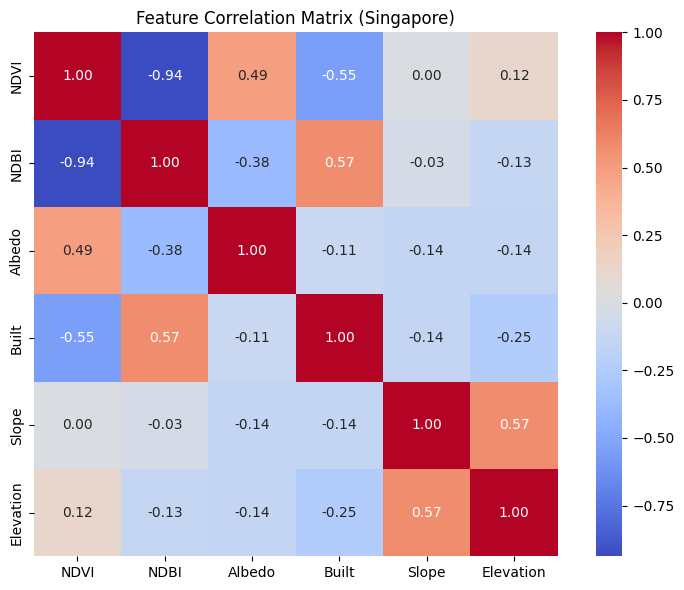

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

features = pd.concat([X_train, X_test])

# Compute correlation matrix
corr_matrix = features.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Feature Correlation Matrix (Singapore)")
plt.tight_layout()
plt.show()


100%|===================| 1139/1142 [01:24<00:00]       

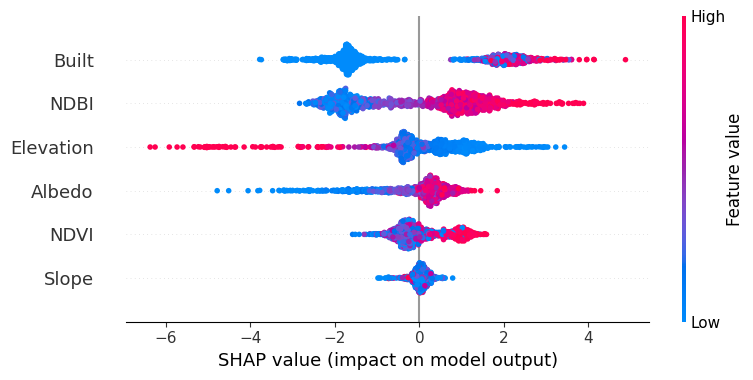

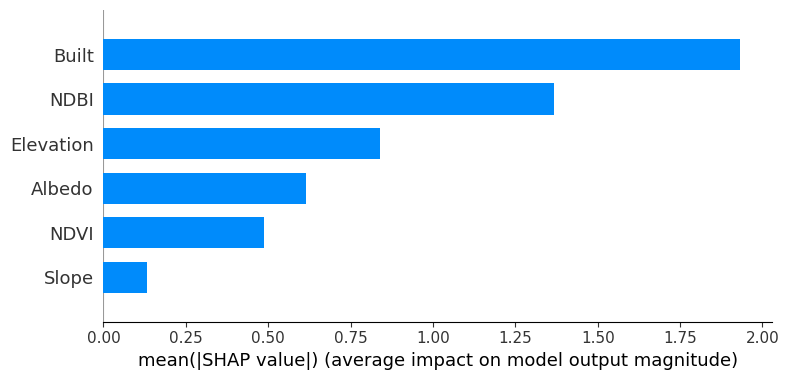

In [ ]:
import shap
import matplotlib.pyplot as plt

# Create SHAP explainer using training data
explainer = shap.Explainer(model, X_train)

# Compute SHAP values on test data
shap_values = explainer(X_test)

# Plot SHAP summary (beeswarm)
shap.summary_plot(shap_values, X_test)

# Optional: Bar plot of global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
df = pd.DataFrame(results)
print(df)
print("\nMAE of UHI Intensity:", mean_absolute_error(df['UHI_Real'], df['UHI_Predicted']))

          Region   UHI_Real  UHI_Predicted
0          Tampa   3.730680       3.621180
1       New York  -3.655800      -3.769066
2         Mumbai  -0.439981      -0.761228
3          Paris   1.834799       1.884214
4    Mexico City -13.069775     -12.640280
5          Cairo  -2.792255      -2.712948
6          Tokyo  -5.462440      -5.574231
7        Beijing   1.314894       1.220989
8        Hamburg  -1.455327      -1.399014
9         Sydney   9.367261       9.322002
10      Shanghai   1.146113       1.147786
11  Buenos Aires   6.665410       6.737608
12         Dhaka   2.084729       1.985896
13        London   0.779570       0.574613
14        Madrid  -0.366845      -0.372684
15       Toronto   9.601153       9.406126
16       Bangkok   4.288367       4.196492
17  Johannesburg  -1.006138      -0.919042
18         Seoul   2.854666       2.700161
19     Singapore   6.625369       6.272744

MAE of UHI Intensity: 0.1337063562154981


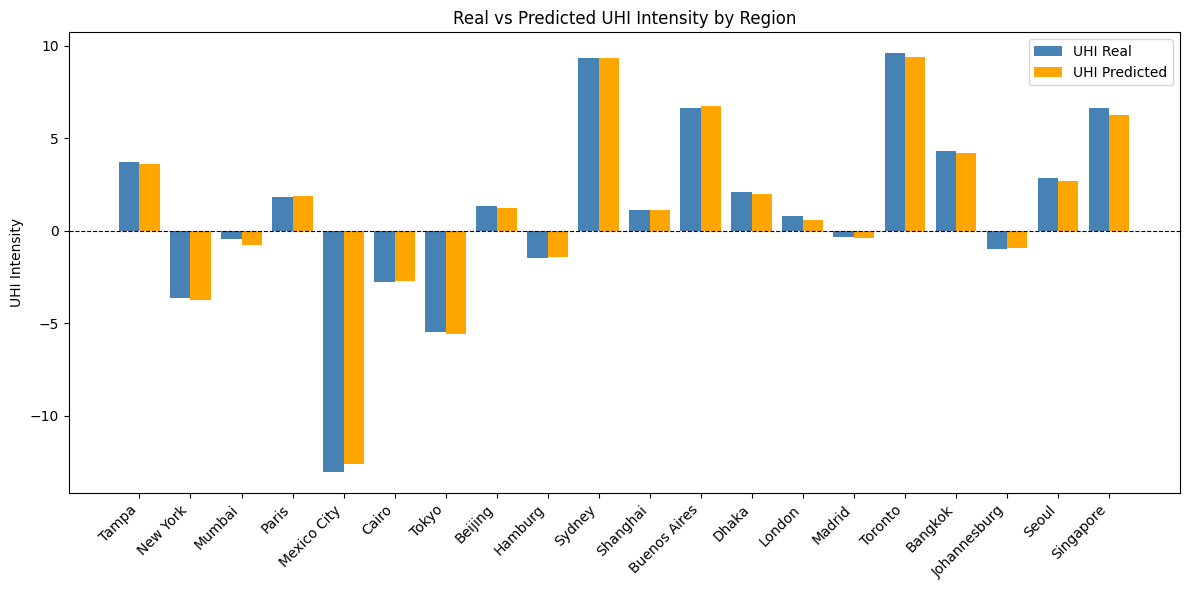

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

x = range(len(df['Region']))
width = 0.4

plt.figure(figsize=(12,6))
plt.bar([p - width/2 for p in x], df['UHI_Real'], width=width, label='UHI Real', color='steelblue')
plt.bar([p + width/2 for p in x], df['UHI_Predicted'], width=width, label='UHI Predicted', color='orange')
plt.xticks(ticks=x, labels=df['Region'], rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylabel('UHI Intensity')
plt.title('Real vs Predicted UHI Intensity by Region')
plt.legend()
plt.tight_layout()
plt.savefig('uhi_bargraph.png', dpi=300, bbox_inches='tight')
plt.show()

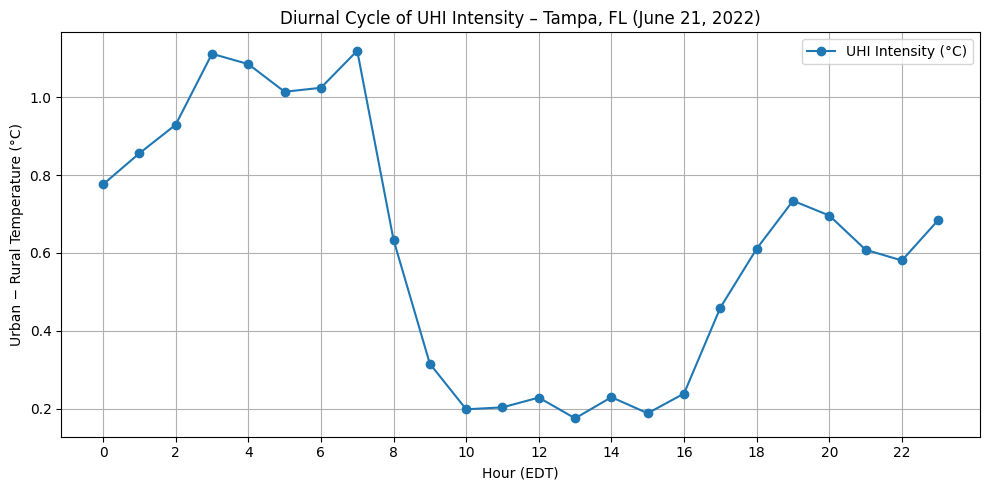

In [ ]:
date = '2022-06-21'
start = f'{date}T00:00'
end = f'{date}T23:59'

urban = ee.Geometry.Point([-82.4572, 27.9506]).buffer(3000)
rural = ee.Geometry.Point([-82.2, 28.1]).buffer(3000)

era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
    .filterDate(start, end) \
    .select('temperature_2m')

def extract_uhi(image):
    urban_mean = image.reduceRegion(ee.Reducer.mean(), urban, 1000).get('temperature_2m')
    rural_mean = image.reduceRegion(ee.Reducer.mean(), rural, 1000).get('temperature_2m')
    diff = ee.Number(urban_mean).subtract(rural_mean)
    return ee.Feature(None, {
        'time': image.date().format('HH'),
        'UHI': diff
    })

uhi_fc = era5.map(extract_uhi)

features = uhi_fc.getInfo()['features']

hours = [(int(f['properties']['time']) - 4) % 24 for f in features]
uhi_values = [f['properties']['UHI'] for f in features]  # convert K to °C

sorted_data = sorted(zip(hours, uhi_values))
hours_sorted, uhi_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 5))
plt.plot(hours_sorted, uhi_sorted, marker='o', label='UHI Intensity (°C)')
plt.title('Diurnal Cycle of UHI Intensity – Tampa, FL (June 21, 2022)')
plt.xlabel('Hour (EDT)')
plt.ylabel('Urban − Rural Temperature (°C)')
plt.grid(True)
plt.xticks(range(0, 24, 2))
plt.legend()
plt.tight_layout()
plt.savefig('diurnal_cycle.png', dpi=300, bbox_inches='tight')
plt.show()


Saved Red_band_100m.png


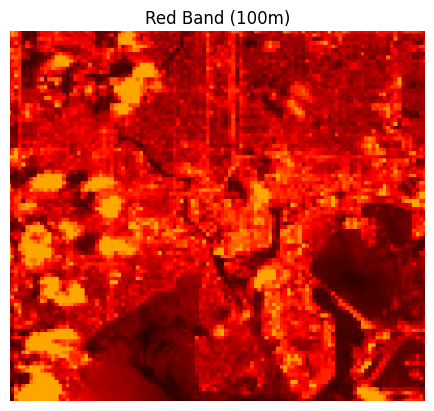

Saved SWIR1_band_100m.png


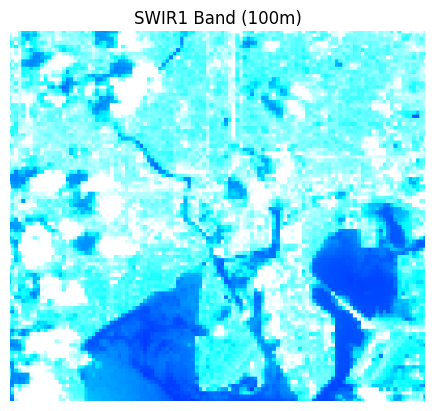

Saved TIR_band_100m.png


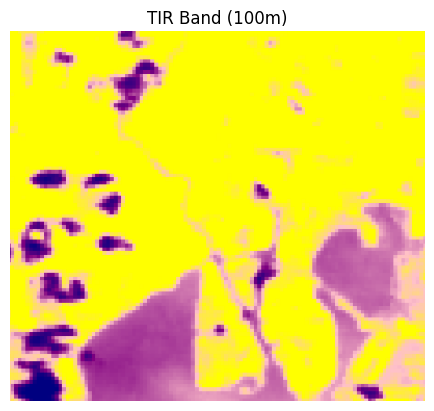

In [ ]:
import ee
import requests
import io
from PIL import Image
import matplotlib.pyplot as plt

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='rock-tower-462119-b0')

# Define point of interest and region (10 km x 10 km square)
point = ee.Geometry.Point([-82.4572, 27.9506])  # Example: Tampa
region = point.buffer(5000).bounds()  # 5000 m = 5 km radius

# Fetch least cloudy Landsat 8 image
image = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(point) \
    .filterDate('2022-06-01', '2022-06-30') \
    .sort('CLOUD_COVER') \
    .first()

# Scale bands and rename
def scale_image(img):
    optical = img.select(['SR_B4', 'SR_B6']).multiply(0.0000275).add(-0.2) \
        .resample('bicubic').reproject(crs='EPSG:4326', scale=100)
    thermal = img.select('ST_B10').multiply(0.00341802).add(149.0) \
        .resample('bicubic').reproject(crs='EPSG:4326', scale=100)
    return optical.addBands(thermal).rename(['Red', 'SWIR1', 'TIR'])

scaled = scale_image(image)

# Define visualization styles with color maps
band_settings = {
    'Red': {
        'bands': ['Red'], 'min': 0, 'max': 0.3,
        'palette': ['black', 'red', 'orange']
    },
    'SWIR1': {
        'bands': ['SWIR1'], 'min': 0, 'max': 0.3,
        'palette': ['blue', 'cyan', 'white']
    },
    'TIR': {
        'bands': ['TIR'], 'min': 290, 'max': 310,
        'palette': ['navy', 'purple', 'pink', 'yellow']
    },
}

# Function to download and save each band as PNG
def download_and_save(band_name):
    vis = band_settings[band_name]
    url = scaled.visualize(**vis).getThumbURL({
        'dimensions': 512,
        'region': region,
        'format': 'png'
    })

    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))

    filename = f'{band_name}_band_100m.png'
    img.save(filename)
    print(f"Saved {filename}")

    # Display
    plt.imshow(img)
    plt.title(f'{band_name} Band (100m)')
    plt.axis('off')
    plt.show()

# Download and display all 3 bands
for band in ['Red', 'SWIR1', 'TIR']:
    download_and_save(band)